<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

---

# <center> Проект: Анализ вакансий из HeadHunter

---

Импортируем нужные нам для работы инструменты.

In [1]:
import pandas as pd
import sqlalchemy
from sqlalchemy import text

Пропишем наши параметры подключения (будут скрыты из версии ноутбук-файла в открытом доступе).

In [2]:
DBNAME = '**********'
USER = '**********'
PASSWORD = '**********'
HOST = '**********'
PORT = '**********'

И создаем соединение.

In [3]:
# Заполним строку подключения нашими параметрами с помощью f-строки.
url = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}'
# Передадим адрес соединения движку.
engine = sqlalchemy.create_engine(url)
# И получаем соединение!
conn = engine.connect()

---

# Знакомство с данными

---

Все необходимые таблицы находятся в схеме базы данных:

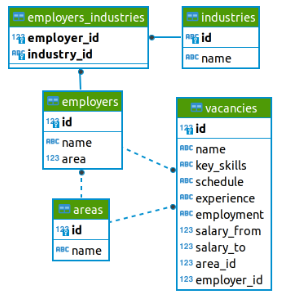

Познакомимся с каждой таблицей.

#### VACANCIES

Таблица хранит в себе данные по вакансиям и содержит следующие столбцы:

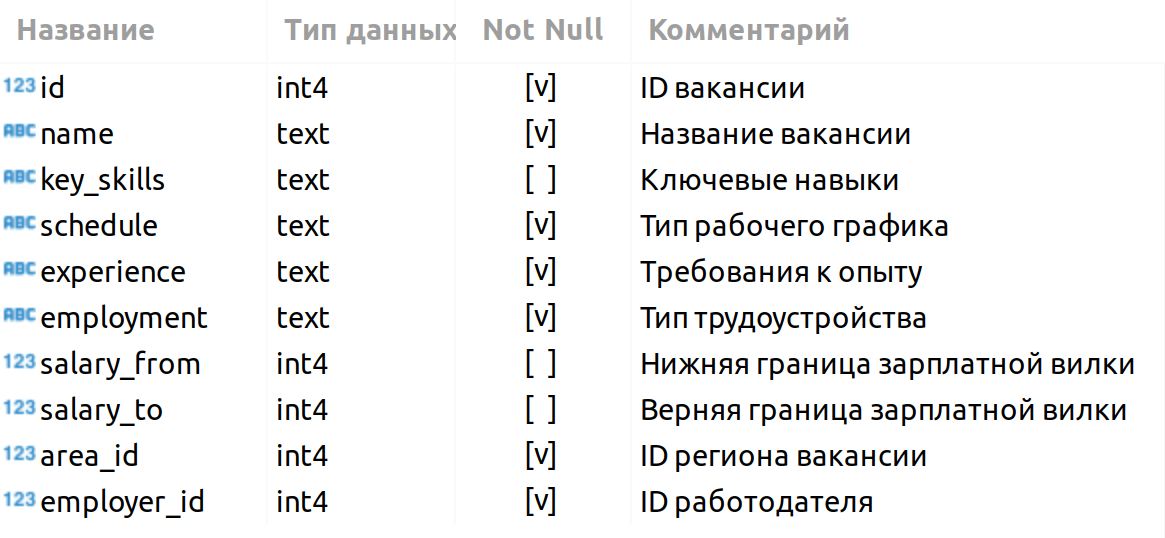

#### AREAS

Таблица-справочник, которая хранит код города и его название.

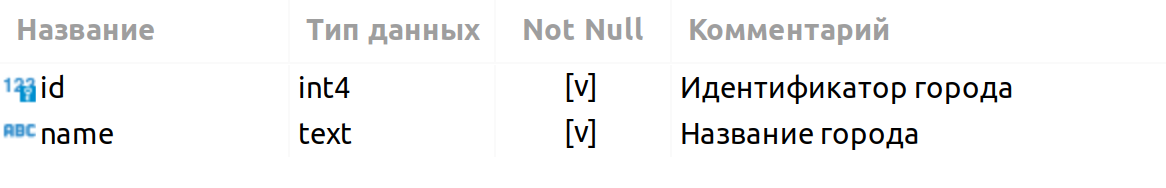

#### EMPLOYERS

Таблица-справочник со списком работодателей.

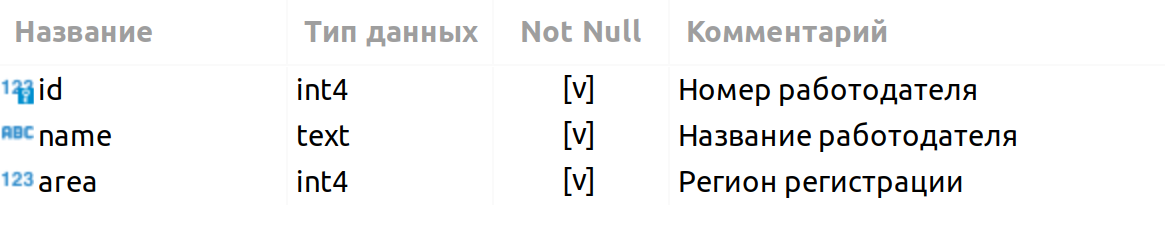

#### INDUSTRIES

Таблица-справочник вариантов сфер деятельности работодателей.

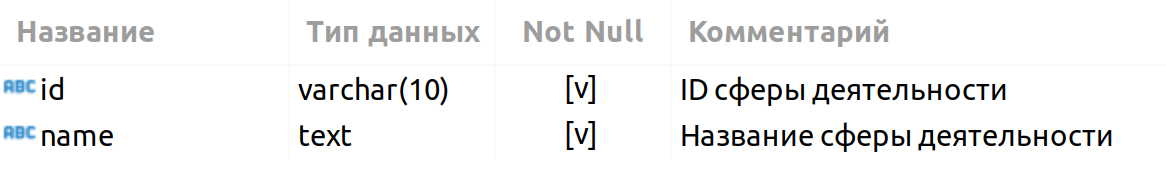

#### EMPLOYERS_INDUSTRIES

Дополнительная таблица, которая существует для организации связи между работодателями и сферами их деятельности.

Эта таблица нужна нам, поскольку у одного работодателя может быть несколько сфер деятельности (или работодатели могут вовсе не указать их). Для удобства анализа необходимо хранить запись по каждой сфере каждого работодателя в отдельной строке таблицы.

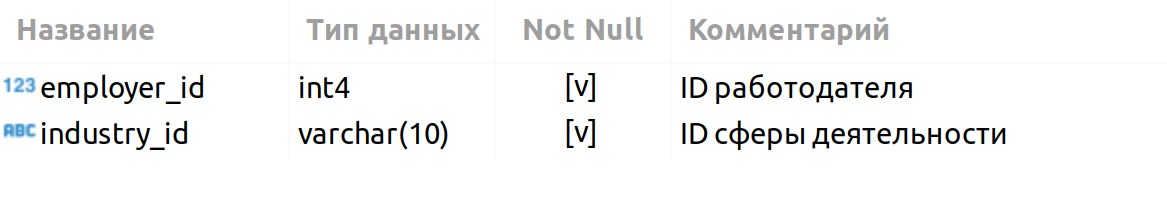

---

# Предварительный анализ данных

---

1. Напишем запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [6]:
# Здесь и далее: присваиваем текст SQL-запроса переменной query.
query = '''SELECT
               COUNT(*)
           FROM vacancies
        '''
# Передаем по соединению с базой данных текст запроса и
# получаем результат...
result = conn.execute(text(query)).fetchall()
# ...из которого затем формируем датафрейм.
vacancies = pd.DataFrame(result)
# И выводим его содержимое.
vacancies

,count
0,49197


---

2. Напишем запрос, который посчитает количество работодателей (таблица employers).

In [115]:
query = '''SELECT
               COUNT(*)
           FROM employers 
        '''

result = conn.execute(text(query)).fetchall()
employers = pd.DataFrame(result)
employers

,count
0,23501


---

3. Посчитаем с помощью запроса количество регионов (таблица areas).

In [117]:
query = '''SELECT
               COUNT(*)
           FROM areas 
        '''

result = conn.execute(text(query)).fetchall()
areas = pd.DataFrame(result)
areas

,count
0,1362


---

4. Посчитаем с помощью запроса количество сфер деятельности в базе (таблица industries).

In [116]:
query = '''SELECT
               COUNT(*)
           FROM industries 
        '''

result = conn.execute(text(query)).fetchall()
areas_of_activity = pd.DataFrame(result)
areas_of_activity

,count
0,294


---

### Выводы по предварительному анализу данных

* Всего в нашем распоряжении находится база из 49197 вакансий.
* Число работодателей в соответствующей таблице почти вдвое меньше - 23501.
* В таблице регионов - 1362 строки.
* Число сфер деятельности работодателей - всего 294.

---

# Детальный анализ вакансий

---

1. Напишем запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируем по количеству вакансий в порядке убывания.

In [118]:
query = '''SELECT
               a.name AS area,
               COUNT(v.id) AS cnt
           FROM areas AS a
               JOIN vacancies AS v ON a.id = v.area_id
           GROUP BY 1
           ORDER BY 2 DESC
           LIMIT 5
        '''

result = conn.execute(text(query)).fetchall()
vacancies_by_area = pd.DataFrame(result)
vacancies_by_area

,area,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


---

2. Напишем запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [35]:
query = '''SELECT
               COUNT(*)
           FROM vacancies
           WHERE salary_from IS NOT NULL 
               OR salary_to IS NOT NULL
        '''

result = conn.execute(text(query)).fetchall()
have_salary = pd.DataFrame(result)
have_salary

,count
0,24073


---

3. Найдем средние значения для нижней и верхней границы зарплатной вилки. Округлим значения до целого.

In [119]:
query = '''SELECT
               ROUND(AVG(salary_from)) AS avg_sf,
               ROUND(AVG(salary_to)) AS avg_st
           FROM vacancies
        '''

result = conn.execute(text(query)).fetchall()
average_for_salaries = pd.DataFrame(result)
average_for_salaries

,avg_sf,avg_st
0,71065,110537


---

4. Напишем запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируем по убыванию количества.

In [120]:
query = '''SELECT
               schedule,
               employment,
               COUNT(*)
           FROM vacancies
           GROUP BY 1, 2
           ORDER BY 3 DESC
        '''

result = conn.execute(text(query)).fetchall()
cnt_by_shed_and_empl = pd.DataFrame(result)
cnt_by_shed_and_empl

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


---

5. Напишем запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта.

In [121]:
query = '''SELECT
               experience,
               COUNT(*)
           FROM vacancies
           GROUP BY 1
           ORDER BY 2
        '''

result = conn.execute(text(query)).fetchall()
cnt_by_exp = pd.DataFrame(result)
cnt_by_exp

,experience,count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


---

### Выводы по детальному анализу вакансий

* Больше всего вакансий, как и ожидалось, размещено в столицах и крупных городах, представляющих собой региональные центры деловой активности.
* Мы также узнали, что у более чем 25 тысяч вакансий отсутствуют сведения о зарплате (таковые имеются только у 24 тысяч).
* Средние значения нижней и верхней границ зарплатной вилки - 71 и 110 тыс. руб. соответственно.
* Наиболее распространенный тип вакансий предполагает полнорабочий день с полной занятостью.
* Чаще всего работодатели ищут тех, кто имеет хотя бы год опыта работы.

---

# Анализ работодателей

---

1. Напишем запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [122]:
query = '''SELECT
               e.name,
               COUNT(v.id)
           FROM employers AS e
               JOIN vacancies AS v ON e.id = v.employer_id
           GROUP BY 1
           ORDER BY 2 DESC
           LIMIT 5
        '''

result = conn.execute(text(query)).fetchall()
top_employers = pd.DataFrame(result)
top_employers

,name,count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


---

2. Напишем запрос, который для каждого региона выведет количество работодателей и вакансий в нём. Среди регионов, в которых нет вакансий, найдем тот, в котором наибольшее количество работодателей.

In [123]:
query = '''SELECT
               a.name,
               COUNT(e.id) AS empl_cnt,
               COUNT(v.id) AS vac_cnt
           FROM areas AS a
               LEFT JOIN employers AS e ON e.area = a.id
               LEFT JOIN vacancies AS v ON v.area_id = a.id
           WHERE v.id IS NULL
           GROUP BY 1
           ORDER BY 2 DESC
           LIMIT 5
        '''

result = conn.execute(text(query)).fetchall()
for_area_empls_and_vacs_cnts = pd.DataFrame(result)
for_area_empls_and_vacs_cnts

,name,empl_cnt,vac_cnt
0,Россия,410,0
1,Казахстан,207,0
2,Московская область,75,0
3,Краснодарский край,19,0
4,Беларусь,18,0


---

3. Для каждого работодателя посчитаем количество регионов, в которых он публикует свои вакансии. Отсортируем результат по убыванию количества.

In [124]:
query = '''SELECT
               e.name,
               COUNT(DISTINCT a.id) AS areas_cnt
           FROM vacancies AS v
               JOIN employers AS e ON e.id = v.employer_id
               JOIN areas AS a ON v.area_id = a.id
           GROUP BY 1
           ORDER BY 2 DESC
           LIMIT 5
        '''

result = conn.execute(text(query)).fetchall()
areas_for_employers = pd.DataFrame(result)
areas_for_employers

,name,areas_cnt
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


---

4. Напишем запрос для подсчёта количества работодателей, у которых не указана сфера деятельности.

In [125]:
query = '''SELECT
               COUNT(e.id)
           FROM employers AS e
               LEFT JOIN employers_industries AS ei ON e.id = ei.employer_id
           WHERE ei.industry_id IS NULL
        '''

result = conn.execute(text(query)).fetchall()
employers_without_industries = pd.DataFrame(result)
employers_without_industries

,count
0,8419


---

5. Напишем запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [126]:
query = '''SELECT
               e.name
           FROM employers AS e
               JOIN employers_industries AS ei ON e.id = ei.employer_id
           GROUP BY 1
           HAVING COUNT(ei.industry_id) = 4
           ORDER BY 1
           LIMIT 5
        '''

result = conn.execute(text(query)).fetchall()
third_employer_with_4industries = pd.DataFrame(result)
third_employer_with_4industries

,name
0,101 Интернет
1,21vek.by
2,2ГИС
3,2К
4,4 пикселя +


---

6. С помощью запроса выясним, у какого количества работодателей в качестве сферы деятельности указана "Разработка программного обеспечения".

In [130]:
query = '''SELECT
               COUNT(e.id)
           FROM employers AS e
               JOIN employers_industries AS ei ON e.id = ei.employer_id
               JOIN industries AS i ON i.id = ei.industry_id
           WHERE i.name = 'Разработка программного обеспечения'
        '''

result = conn.execute(text(query)).fetchall()
cnt_software_devs = pd.DataFrame(result)
cnt_software_devs

,count
0,3553


---

7. Для компании «Яндекс» выведем список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавим строку Total с общим количеством вакансий компании. Результат отсортируем по возрастанию количества.

Список городов-милионников возьмем [ацюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

In [12]:
# Импортируем библиотеку для парсинга данных из таблицы в статье Википедии.
import urllib.parse as req
# Передаем адрес статьи методу urlparse для разложения общего пути на компоненты.
path_common = req.urlparse('https://ru.wikipedia.org/wiki/Города-миллионеры_России#Список_городов-миллионеров')
# Присвоим переменной url адрес пересобранный из именованных атрибутов метода.
url = path_common.scheme + '://' + req.quote(path_common.netloc) + req.quote(path_common.path) + '#'+ req.quote(path_common.fragment) 
# Считаем с помощью метода Pandas этот адрес и образуем кортеж из значений столбца с названиями городов.
cities = tuple(pd.read_html(url)[1]['Город'])
# Далее - передаем кортеж с помощью f-строки и формируем SQL-запрос.
query = f'''with x as (
           SELECT
               a.name AS name,
               COUNT(v.id) AS cnt
           FROM vacancies AS v
               JOIN employers AS e ON e.id = v.employer_id
               JOIN areas AS a ON a.id = v.area_id
           WHERE e.name = 'Яндекс'
               AND a.name in {cities}
           GROUP BY 1
           ORDER BY 2
           )
           
           SELECT *
           FROM x
           
           UNION ALL
           
           SELECT
               'Total',
               SUM(cnt)
           FROM x
        '''

result = conn.execute(text(query)).fetchall()
vacs_in_mlnrs = pd.DataFrame(result)
vacs_in_mlnrs

,name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Уфа,26
8,Самара,26
9,Краснодар,30


---

### Выводы по анализу работодателей

* В топ-5 по количеству размещенных вакансий лидирует Яндекс, следом идут - Ростелеком, Тинькофф, СБЕР и Газпром нефть.
* Мы узнали число таких компаний, местом регистрации подавляющей части из которых указаны целые регионы и даже страны: это, возможно, объяснимо тем, что для них непринципиальна жесткая привязка к конкретным точкам на карте. Вероятный пример: IT-фирма с вакансиями на удаленке. Плюс к тому, мы выяснили, что таблица с регионами предоставляет перечень географических наименований, превышающий потребности как таблицы вакансий, так и таблицы работодателей (есть места без работодателей и вакансий): либо именно так выглядят последствия предобработки данных, либо первая таблица составлена, так сказать, "на вырост".
* Яндекс также лидирует по территориальному охвату поиска специалистов: их вакансии размещены в 181 регионе. Следом идут Ростелеком, Спецремонт и некто Поляков Денис Иванович (два последних специализируются на ремонте и обслуживании компов): ищет специалистов в 88 разных городах - охват для ИП впечатляющий!
* Довольно немало работодателей не указали сферу своей деятельности (таковых 8419). Это могут быть компании, как производящие широкий спектр продуктов, так и предоставляющие уникальные услуги и товары в своем регионе. Возможно также, что сфера деятельности могла быть не указана потому, что она бы явно продублировала часть названия компании, по которой итак не составляет труда составить мнение о том, чем она живет. Нельзя исключать также банальную ошибку некорректного ввода информации в анкету на HH, либо вовсе утрату данных по какой-либо причине. А еще какие-то из компаний могли ограничиться лишь ссылкой на свои сайты, проигнорировав поле для ввода сферы деятельности: "Соискателю же достаточно просто кликнуть!".
* Напротив, есть компании, указывающие несколько сфер деятельности: например, у 2ГИС их целых 4.
* 3553 работодателя указали в качестве своей сферы деятельности - "Разработку программного обеспечения". Это довольно важная характеристика размера IT-сферы в регионе.
* Только четверть из всех вакансий Яндекса приходится на 16 городов-миллионников России.

---

# Предметный анализ

Переходим к самому интересному — нам предстоит исследовать требования работодателей к дата-сайентистам.

---

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'. Также учтем регистр названий вакансий.

In [12]:
query = '''SELECT
               COUNT(v.id)
           FROM vacancies AS v
           WHERE LOWER(v.name) LIKE '%data%'
               OR LOWER(v.name) LIKE '%данн%'
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs = pd.DataFrame(result)
ds_vacs

,count
0,1771


---

2. Сколько же есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (тут учтем, что нам не нужны вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.

In [35]:
query = '''SELECT
               COUNT(id)
           FROM vacancies
           WHERE (LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%')
               AND (LOWER(name) LIKE '%junior%'
               OR experience = 'Нет опыта'
               OR employment = 'Стажировка')
        '''

result = conn.execute(text(query)).fetchall()
vacs_for_jun_ds = pd.DataFrame(result)
vacs_for_jun_ds

,count
0,51


---

3. Попробуем узнать - сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

In [37]:
query = '''SELECT
               COUNT(id)
           FROM vacancies
           WHERE (LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%')
               AND (LOWER(key_skills) LIKE '%sql%'
               OR LOWER(key_skills) LIKE '%postgres%')
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_with_sql_or_pg_skills = pd.DataFrame(result)
ds_vacs_with_sql_or_pg_skills

,count
0,201


---

4. Проверим, насколько популярен Python в требованиях работодателей к DS.Для этого вычислим количество вакансий, в которых в качестве ключевого навыка указан Python.

In [38]:
query = '''SELECT
               COUNT(id)
           FROM vacancies
           WHERE (LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%')
               AND LOWER(key_skills) LIKE '%python%'
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_with_python_skills = pd.DataFrame(result)
ds_vacs_with_python_skills

,count
0,351


---

5. Но сколько же ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлим для удобства до двух знаков после точки-разделителя.

In [41]:
query = '''SELECT
               ROUND(AVG(LENGTH(key_skills) - LENGTH(REPLACE(key_skills, '\t', '')) + 1), 2)
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_avg_cnt_skills = pd.DataFrame(result)
ds_vacs_avg_cnt_skills

,round
0,6.41


---

6. Напишем запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примем во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null. Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим.

Выясним, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлим до целого числа.

In [45]:
query = '''SELECT
               experience,
               ROUND(AVG(COALESCE((salary_from+salary_to)/2, salary_from, salary_to)), 2)
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_avg_for_exp_types = pd.DataFrame(result)
ds_vacs_avg_for_exp_types

,experience,round
0,Более 6 лет,None
1,Нет опыта,74642.86
2,От 1 года до 3 лет,139674.75
3,От 3 до 6 лет,243114.67


---

### Выводы по предметному анализу

* Примерно 1771 вакансия имеет отношение к данным.
* Всего примерно 51 вакансия подходит для начинающих дата-саентистов. Если пролистать эти вакансии вручную, то релевантных окажется несколько меньше. Впрочем, как и ожидалось, мало кто готов брать к себе джуна (:
* Примерное число вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres, - 201. Результат в четыре раза больше предыдущего. Однако нельзя отнести весь прирост только на долю указанных ключевых навыков: здесь мы уже убрали фильтры для джуна. Плюс к тому, опять же, не все результаты запроса могут быть релевантными. Но наличие дополнительных скиллов, разумеется, даст некоторое конкурентное преимущество при поиске работы.
* Python-навыки являются очевидной базой для многих вакансий, тогда как знание SQL подразумевает большую специализированность. 351 вакансия среди прочих требований к соискателям в качестве ключевого навыка указывает Python.
* В среднем же работодатели указывают 6 и более ключевых навыков.
* На момент составления таблицы вакансий миддл-специалисты (опыт работы 3-6 лет) вполне могли расчитывать на з/п в размере до 250К руб.

---

# Общий вывод по проекту

### И дополнительные исследования

---

Итак, мы уже провели некоторую работу над данными в связанных таблицах, содержащих сведения о вакансиях в сфере IT. Но для составления более содержательных рекомендаций для претендующих на позицию Data Scientist не помешает провести дополнительные исследования.

---

Для начала выведем топ-20 самых распространенных вакансий.

In [25]:
query = '''SELECT
               name,
               count(*)
           FROM vacancies AS v
           GROUP BY 1
           ORDER BY 2 DESC
        '''

result = conn.execute(text(query)).fetchall()
pop_vacs = pd.DataFrame(result)
pop_vacs.head(20)

,name,count
0,Системный администратор,1761
1,Программист 1С,1153
2,Бизнес-аналитик,488
3,Специалист технической поддержки,457
4,Системный аналитик,432
5,Аналитик,404
6,Инженер-программист,389
7,Программист 1C,360
8,Frontend-разработчик,242
9,Инженер технической поддержки,230


---

Также можно воспользоваться средствами Pandas для анализа интересующих нас параметров итогового датафрейма.

In [59]:
query = '''SELECT
               name,
               key_skills,
               schedule,
               experience
           FROM vacancies
        '''

result = conn.execute(text(query)).fetchall()
describe_vacs = pd.DataFrame(result)
describe_vacs.describe()

,name,key_skills,schedule,experience
count,49197,40741,49197,49197
unique,21223,31218,5,4
top,Системный администратор,1С программирование,Полный день,От 1 года до 3 лет
freq,1761,94,36424,26152


---

Выведем 10 самых распространенных вакансий, сгруппированных по региону и требуемому опыту работы.

In [6]:
query = '''SELECT
               a.name,
               v.name,
               v.experience,
               count(*)
           FROM vacancies AS v
               JOIN areas AS a ON a.id = v.area_id
           GROUP BY 1, 2, 3
           ORDER BY 4 DESC
        '''

result = conn.execute(text(query)).fetchall()
vacs_from_areas = pd.DataFrame(result)
vacs_from_areas.head(10)

,name,name,experience,count
0,Москва,Бизнес-аналитик,От 1 года до 3 лет,95
1,Москва,Бизнес-аналитик,От 3 до 6 лет,71
2,Санкт-Петербург,Системный администратор,От 1 года до 3 лет,42
3,Москва,Аналитик,От 1 года до 3 лет,41
4,Новосибирск,Системный администратор,От 1 года до 3 лет,33
5,Санкт-Петербург,Бизнес-аналитик,От 1 года до 3 лет,31
6,Нижний Новгород,Системный администратор,От 1 года до 3 лет,31
7,Казань,Системный администратор,От 1 года до 3 лет,31
8,Минск,Системный администратор,От 1 года до 3 лет,31
9,Екатеринбург,Программист 1С,От 1 года до 3 лет,30


---

Теперь выведем с той же группировкой уже только вакансии без сведений о предлагаемой зарплате.

In [7]:
query = '''SELECT
               a.name,
               v.name,
               v.experience,
               count(*)
           FROM vacancies AS v
               JOIN areas AS a ON a.id = v.area_id
           WHERE v.salary_from IS NULL
               AND v.salary_to IS NULL
           GROUP BY 1, 2, 3
           ORDER BY 4 DESC
        '''

result = conn.execute(text(query)).fetchall()
vacs_from_areas_with_salary_null = pd.DataFrame(result)
vacs_from_areas_with_salary_null.head(10)

,name,name,experience,count
0,Москва,Бизнес-аналитик,От 1 года до 3 лет,73
1,Москва,Бизнес-аналитик,От 3 до 6 лет,53
2,Москва,Аналитик,От 1 года до 3 лет,31
3,Москва,Аналитик данных,От 1 года до 3 лет,26
4,Новосибирск,Системный аналитик,От 1 года до 3 лет,22
5,Москва,Системный аналитик,От 1 года до 3 лет,21
6,Москва,Системный аналитик,От 3 до 6 лет,20
7,Санкт-Петербург,Бизнес-аналитик,От 1 года до 3 лет,17
8,Казань,Системный аналитик,От 1 года до 3 лет,16
9,Санкт-Петербург,Системный аналитик,От 1 года до 3 лет,16


---

Выведем рейтинг самых распространенных вакансий среди тех, что вероятнее всего относятся к DS, сгруппированных по требуемому опыту работы.

In [10]:
query = '''WITH x AS (SELECT
               name,
               experience,
               count(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2
           ORDER BY 3 DESC
           )
           
           SELECT *
           FROM x
           
           UNION ALL
           
           SELECT
               'Total',
               '---',
               SUM(cnt)
           FROM x
        '''

result = conn.execute(text(query)).fetchall()
pop_ds_vacs = pd.DataFrame(result)
display(pop_ds_vacs.head(12), pop_ds_vacs.tail(5))

,name,experience,cnt
0,Data Scientist,От 1 года до 3 лет,33
1,Data Scientist,От 3 до 6 лет,21
2,Senior Data Scientist,Более 6 лет,14
3,Junior Data Scientist (Валидация скоринговых м...,От 1 года до 3 лет,9
4,ML Engineer/ Data Scientist (WAF),От 3 до 6 лет,9
5,C++ разработчик (QML),От 3 до 6 лет,9
6,Middle Data Scientist,От 3 до 6 лет,7
7,Архитектор решений с опытом в Tiny ML,Более 6 лет,6
8,Python-разработчик в команду Data Science,От 3 до 6 лет,5
9,Data scientist,От 1 года до 3 лет,5


,name,experience,cnt
300,Data Scientist / ML-инженер (Big Data),От 3 до 6 лет,1
301,Data Scientist / ML-разработчик,От 1 года до 3 лет,1
302,Data Scientist (MTS AI),От 3 до 6 лет,1
303,Data scientist / Product analyst,От 1 года до 3 лет,1
304,Total,---,480


---

Теперь с той же группировкой уже только вакансии без сведений о предлагаемой зарплате.

In [13]:
query = '''WITH x AS (SELECT
               name,
               experience,
               count(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
               AND salary_from IS NULL
               AND salary_to IS NULL
           GROUP BY 1, 2
           ORDER BY 3 DESC
           )
           
           SELECT *
           FROM x
           
           UNION ALL
           
           SELECT
               'Total',
               '---',
               SUM(cnt)
           FROM x
        '''

result = conn.execute(text(query)).fetchall()
pop_ds_vacs_with_salary_null = pd.DataFrame(result)
display(pop_ds_vacs_with_salary_null.head(12), pop_ds_vacs_with_salary_null.tail(5))

,name,experience,cnt
0,Data Scientist,От 1 года до 3 лет,33
1,Data Scientist,От 3 до 6 лет,21
2,Senior Data Scientist,Более 6 лет,14
3,Junior Data Scientist (Валидация скоринговых м...,От 1 года до 3 лет,9
4,ML Engineer/ Data Scientist (WAF),От 3 до 6 лет,9
5,C++ разработчик (QML),От 3 до 6 лет,9
6,Middle Data Scientist,От 3 до 6 лет,7
7,Архитектор решений с опытом в Tiny ML,Более 6 лет,6
8,Python-разработчик в команду Data Science,От 3 до 6 лет,5
9,Data scientist,От 1 года до 3 лет,5


,name,experience,cnt
296,Data Scientist / ML-инженер,От 1 года до 3 лет,1
297,Data Scientist / ML-инженер (Big Data),От 3 до 6 лет,1
298,Data Scientist / ML-разработчик,От 1 года до 3 лет,1
299,Data Scientist (MTS AI),От 3 до 6 лет,1
300,Total,---,475


---

Сгруппируем вакансии имеющие отношение к DS по типу графика.

In [16]:
query = '''SELECT
               name,
               schedule,
               count(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2
           ORDER BY 3 DESC
        '''

result = conn.execute(text(query)).fetchall()
pop_ds_vacs_with_sched = pd.DataFrame(result)
pop_ds_vacs_with_sched.head(12)

,name,schedule,cnt
0,Data Scientist,Полный день,45
1,Senior Data Scientist,Удаленная работа,14
2,ML Engineer/ Data Scientist (WAF),Гибкий график,9
3,Junior Data Scientist (Валидация скоринговых м...,Полный день,9
4,C++ разработчик (QML),Гибкий график,9
5,Data Scientist,Удаленная работа,8
6,Middle Data Scientist,Удаленная работа,7
7,Senior Data Scientist,Полный день,7
8,Data scientist,Полный день,6
9,Архитектор решений с опытом в Tiny ML,Удаленная работа,6


---

Теперь распределим вакансии только по типам графика и типу трудоустройства и посчитаем, сколько их в каждой группе.

In [5]:
query = '''SELECT
               schedule,
               employment,
               count(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2
           ORDER BY 3 DESC
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_by_sched = pd.DataFrame(result)
ds_vacs_by_sched.head(12)

,schedule,employment,cnt
0,Полный день,Полная занятость,319
1,Удаленная работа,Полная занятость,110
2,Гибкий график,Полная занятость,37
3,Гибкий график,Частичная занятость,4
4,Удаленная работа,Частичная занятость,3
5,Полный день,Стажировка,2
6,Удаленная работа,Проектная работа,2
7,Гибкий график,Стажировка,2
8,Полный день,Частичная занятость,1


---

Снова проанализируем получившуюся выборку с помощью метода describe. А также выведем в столбик самый распространенный сет требуемых скиллов для DS.

In [13]:
query = '''SELECT
               name,
               key_skills,
               schedule,
               employment,
               experience
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
        '''

result = conn.execute(text(query)).fetchall()
describe_vacs_for_ds = pd.DataFrame(result)
# Здесь, помимо описательной статистики таблицы вакансий, выведем
# с помощью генератора списков содержимое параметра key_skills. 
display(describe_vacs_for_ds.describe(), 
        *[x for x in describe_vacs_for_ds.describe().at['top', 'key_skills'].split('\t')])

,name,key_skills,schedule,employment,experience
count,480,431,480,480,480
unique,286,318,3,4,4
top,Data Scientist,Python\tMachine Learning\tData Analysis\tNumpy...,Полный день,Полная занятость,От 1 года до 3 лет
freq,55,14,322,466,223


'Python'

'Machine Learning'

'Data Analysis'

'Numpy'

'Pandas'

---

Выведем таблицу скиллов для DS.

In [14]:
query = '''SELECT
               key_skills,
               COUNT(*)
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1
           ORDER BY 2 DESC
        '''

result = conn.execute(text(query)).fetchall()
pop_ds_vacs_key_skills = pd.DataFrame(result)
# Для лучшей читаемости содержимого столбца ключевых навыков обработаем значения с помощью lambda-функции.
pop_ds_vacs_key_skills['key_skills'] = pop_ds_vacs_key_skills['key_skills'].apply(lambda x: x if x is None else x.split('\t'))
# Изменим параметр отображения датафрейма, сняв ограничение на количество выводимых символов.
pd.set_option('display.max_colwidth', None)
# Отобразим получившийся результат.
pop_ds_vacs_key_skills.head(12)

,key_skills,count
0,None,49
1,"[Python, Machine Learning, Data Analysis, Numpy, Pandas]",14
2,"[Оценка рисков, MS PowerPoint, Статистический анализ, Управление рисками, Математическое моделирование, PD, LGD, EAD, SQL, Портфельные риски, кредитные риски]",13
3,"[Qt, ООП, C++, MS Visual Studio, Разработка компьютерных Игр, QML]",9
4,"[Python, machine learning, web security, sklearn, pytorch, docker]",9
5,"[Git, ООП, Atlassian Jira, Java, Atlassian Confluence]",7
6,"[Python, SQL, Data Mining, Аналитические исследования, NLP]",6
7,"[Python, Learning to Rank, Data Science, NLP]",6
8,"[Python, Docker, Machine Learning, Data Science, k8s]",5
9,"[TinyML, Embedded, Solution Architect, Архитектор решений, C++, С]",4


---

Теперь добавим группировку по именам вакансий, чтобы выяснить к кому именно такие требования выставляются.

In [17]:
query = '''SELECT
               key_skills,
               COUNT(*),
               name
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 3
           ORDER BY 2 DESC
        '''

result = conn.execute(text(query)).fetchall()
pop_ds_vacs_key_skills_groupt = pd.DataFrame(result)
# Снова воспользуемся lambda-функцией.
pop_ds_vacs_key_skills_groupt['key_skills'] = pop_ds_vacs_key_skills_groupt['key_skills'].apply(lambda x: x if x is None else x.split('\t'))
# Измененный параметр отображения сохраняется и здесь.
pop_ds_vacs_key_skills_groupt.head(12)

,key_skills,count,name
0,"[Python, Machine Learning, Data Analysis, Numpy, Pandas]",14,Senior Data Scientist
1,"[Python, machine learning, web security, sklearn, pytorch, docker]",9,ML Engineer/ Data Scientist (WAF)
2,"[Оценка рисков, MS PowerPoint, Статистический анализ, Управление рисками, Математическое моделирование, PD, LGD, EAD, SQL, Портфельные риски, кредитные риски]",9,Junior Data Scientist (Валидация скоринговых моделей)
3,"[Qt, ООП, C++, MS Visual Studio, Разработка компьютерных Игр, QML]",9,C++ разработчик (QML)
4,None,8,Data Scientist
5,"[Git, ООП, Atlassian Jira, Java, Atlassian Confluence]",6,Архитектор решений с опытом в Tiny ML
6,"[Python, SQL, Data Mining, Аналитические исследования, NLP]",6,Data Scientist
7,"[Python, Learning to Rank, Data Science, NLP]",6,Middle Data Scientist
8,"[Python, Docker, Machine Learning, Data Science, k8s]",5,Python-разработчик в команду Data Science
9,"[TinyML, Embedded, Solution Architect, Архитектор решений, C++, С]",4,Архитектор решений (с опытом в TinyML)


---

Посмотрим на вакансии без сведений о требуемых ключевых навыках.

In [37]:
query = '''SELECT
               name,
               experience,
               key_skills,
               count(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2, 3
           HAVING key_skills IS NULL
           ORDER BY 4 DESC
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_by_sched = pd.DataFrame(result)
ds_vacs_by_sched.head(12)

,name,experience,key_skills,cnt
0,Data Scientist,От 3 до 6 лет,None,4
1,Data Scientist,От 1 года до 3 лет,None,4
2,Senior Data Scientist,От 1 года до 3 лет,None,3
3,"Аналитик BI, Data Scientist, BI Architect",От 3 до 6 лет,None,2
4,Middle-Senior Data Scientist,От 1 года до 3 лет,None,2
5,ML engineer,От 1 года до 3 лет,None,2
6,Автор работ по машинному обучению,От 1 года до 3 лет,None,2
7,Data Scientist (Группа сервисов вычислительной химии),От 1 года до 3 лет,None,1
8,Data scientist (Персонализация),От 1 года до 3 лет,None,1
9,Data scientist (розничные риски),От 1 года до 3 лет,None,1


---

Посмотрим на вакансии для соискателей без опыта работы.

In [81]:
query = '''SELECT
               v.name,
               v.experience,
               v.key_skills,
               count(*) AS cnt,
               e.name
           FROM vacancies AS v
               JOIN employers AS e ON v.employer_id = e.id
           WHERE LOWER(v.name) LIKE '%data scientist%'
               OR LOWER(v.name) LIKE '%data science%'
               OR LOWER(v.name) LIKE '%исследователь данных%'
               OR v.name LIKE '%ML%' AND LOWER(v.name) NOT LIKE '%html%'
               OR LOWER(v.name) LIKE '%machine learning%'
               OR LOWER(v.name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2, 3, 5
           HAVING v.experience = 'Нет опыта'
           ORDER BY 4 DESC
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_by_sched = pd.DataFrame(result)
ds_vacs_by_sched['key_skills'] = ds_vacs_by_sched['key_skills'].apply(lambda x: x if x is None else x.split('\t'))
ds_vacs_by_sched.head(10)

,name,experience,key_skills,cnt,name
0,Data Scientist/Machine Learning Engineer (Developer),Нет опыта,"[Machine Learning, Deep Learning, Data Science, Computer Vision, Python, ML, математика, теория групп, алгебра Ли, прикладная математика]",3,Comexp
1,Ведущий AI/ML инженер,Нет опыта,"[Python, Unix, Аналитическое мышление, Нейронные сети, Машинное обучение, Искусственный интеллект, CV]",2,SteadyControl
2,Data Scientist (Computer Vision) / Junior,Нет опыта,"[Python, Linux, Git, SQL, Docker, Bash, OpenCV, Tesseract, Numpy, Jupyter, Machine learning]",1,DNS Головной офис
3,Data Scientist (Junior),Нет опыта,"[Python, Machine Learning, Pandas, SQL, Numpy, Big Data, NLP, Sas]",1,Строительный Двор
4,"Data Scientist, Junior",Нет опыта,"[Python, SQL, Java, Математический анализ, Математическая статистика, R, Jupiter, MATLAB, mathematica]",1,Диплей
5,"Data Scientist, Junior",Нет опыта,"[Python, SQL, Java, Математический анализ, Математическая статистика, R, Mathematica, Jupiter, MATLAB]",1,Диплей
6,Data scientist (Junior/Middle) в консалтинг,Нет опыта,"[Python, ML]",1,БСТ Менеджмент-Консалтинг
7,Data Scientist/ML engineer (Python/C++),Нет опыта,"[ML, линейные модели, Random Forest, Gradient Boosting]",1,"Миррико, Группа Компаний"
8,Data Scientist в Сбер,Нет опыта,None,1,СБЕР
9,Intern/Junior Data Scientist,Нет опыта,"[Linux, Python]",1,"СтарЛайн, Научно-производственное объединение"


---

Выведем вакансии без опыта работы и без ключевых навыков.

In [79]:
query = '''SELECT
               v.name,
               v.schedule,
               v.employment,
               v.experience,
               v.key_skills,
               e.name
           FROM vacancies AS v
               JOIN employers AS e ON v.employer_id = e.id
           WHERE LOWER(v.name) LIKE '%data scientist%'
               OR LOWER(v.name) LIKE '%data science%'
               OR LOWER(v.name) LIKE '%исследователь данных%'
               OR v.name LIKE '%ML%' AND LOWER(v.name) NOT LIKE '%html%'
               OR LOWER(v.name) LIKE '%machine learning%'
               OR LOWER(v.name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2, 3, 4, 5, 6
           HAVING v.experience = 'Нет опыта'
               AND v.key_skills IS NULL
        '''

result = conn.execute(text(query)).fetchall()
ds_vacs_wo_exp_and_ks = pd.DataFrame(result)
ds_vacs_wo_exp_and_ks

,name,schedule,employment,experience,key_skills,name
0,Data Scientist в Сбер,Полный день,Полная занятость,Нет опыта,None,СБЕР
1,Риск-аналитик (ML Engineer / Data Scientist),Полный день,Полная занятость,Нет опыта,None,АЛЬФА-БАНК


---

Выведем число уникальных ключевых навыков для вакансий, имеющих отношение к DS, и частоту встречаемости каждого из наиболее популярной тридцатки.

In [20]:
# Импортируем класс счетчиков из библиотеки коллекций.
from collections import Counter
# Сформируем запрос.
query = '''SELECT
               name,
               key_skills,
               COUNT(*) AS cnt
           FROM vacancies
           WHERE LOWER(name) LIKE '%data scientist%'
               OR LOWER(name) LIKE '%data science%'
               OR LOWER(name) LIKE '%исследователь данных%'
               OR name LIKE '%ML%' AND LOWER(name) NOT LIKE '%html%'
               OR LOWER(name) LIKE '%machine learning%'
               OR LOWER(name) LIKE '%машинн%обучен%'
           GROUP BY 1, 2
               HAVING key_skills IS NOT NULL
        '''
# Присвоим результат соответствующей переменной.
result = conn.execute(text(query)).fetchall()
# Преобразуем его в датафрейм.
ds_vacs_skills = pd.DataFrame(result)
# Воспользуемся lambda-функцией для получения списков в значениях параметра ключевых навыков.
ds_vacs_skills['key_skills'] = ds_vacs_skills['key_skills'].apply(lambda x: x if x is None else x.split('\t'))
# Создадим объект-множество, для формирования перечня уникальных скиллов.
all_skills = set()
# Пройдемся циклами по содержимому списков требуемых ключевых навыков и добавим каждый из них в множество.
for x in ds_vacs_skills['key_skills']:
    for i in x:
        all_skills.add(i)

# Создадим счетчик навыков.
skills_counter = Counter()
# Пройдемся циклом по каждой коллекции ключевых навыков, добавляя их поочередно в объект-счетчик.
for x in ds_vacs_skills['key_skills']:
    skills_counter += Counter(x)

# Выведем общее число навыков.
print(f'Число уникальных ключевых навыков: {len(all_skills)}.')
# Отступ для красоты!
print()
# Комментарий к "комментарию" (:
print('Ключевой навык и частота его встречаемости:')
# Сформируем объект-серию из счетчика.
skills_counter_s = pd.Series(skills_counter)
# Выводим топ-30.
skills_counter_s.sort_values(ascending=False).head(30)

Число уникальных ключевых навыков: 422.

Ключевой навык и частота его встречаемости:


Python                          280
SQL                             161
Machine Learning                 86
Математическая статистика        58
Git                              56
Linux                            44
Анализ данных                    44
ML                               42
Data Science                     41
Английский язык                  41
Big Data                         40
PyTorch                          40
Data Analysis                    36
Pandas                           36
Spark                            34
Hadoop                           31
Tensorflow                       29
Машинное обучение                28
Математическое моделирование     28
Математический анализ            27
NLP                              26
Статистический анализ            26
Docker                           25
C++                              24
Numpy                            21
Аналитическое мышление           21
Java                             19
PostgreSQL                  

---

### Подведем итоги

* Мы вывели топ-20 IT-профессий, и на первом месте - системный администратор. А вот вакансий, связанных с DS, мы в двадцатке не увидели. Тем, кто поначалу бывает твердо намерен найти работу именно в области науки о данных, не стоит отчаиваться, если подолгу не удается реализовать свои желания: в IT много разных профессий и потребностей, а выучиться и обрести приемлемый уровень знаний при имеющихся нынче возможностях не особенно трудно, главное - верная мотивация.
* Так в десятке самых распространенных вакансий, сгруппированных по региону и требуемому опыту работы, лидирует вакансия бизнес-аналитика в Москве: требуются специалисты с опытом работы больше года.
* Вообще профессии, связанные с аналитикой, ближе прочих к DS. И это самые распространенные вакансии без сведений о предлагаемой заработной плате: оплата обгаваривается и определяется индивидуально исходя из способностей соискателя и типов задач, которые ему решатся доверить на работе.
* В нашей базе почти 500 предположительно имеющих отношение к DS вакансий. И практически все из них также не имеют сведений о предлагаемой з/п: это, видимо, специфика сферы: отдача от вложений в труд специалиста сложно прогназируема и оценка результативности деятельности требует продолжительной истории взаимодействия между специалистом и рабочим коллективом.
* Наиболее распространенная пара типов графика и трудоустройства - "полный день"-"полная занятость".
* Самый распространенный сет требуемых скиллов для DS включает в себя: разумеется, знание языка Python, умение работать с библиотеками Pandas и Numpy, анализ данных и машинное обучение.
* Нередко вакансии вовсе не содержат перечень требуемых ключевых навыков: либо у данных работодателей все познается на практике, либо они готовы взращивать новых специалистов под себя.
* Выяснилось, что установленный ранее наиболее популярный сет скиллов выставлялся в вакансиях для Senior Data Scientist: в данном случае требуемые ключевые навыки следует трактовать не столько вширь, сколько вглубь; но, вероятно, также необходимо принять к сведению больше условный характер приведенного перечня навыков: Senior - это все же уровень "специалист-оркестр", и список из пяти элементов не может исчерпывать весь его рабочий репертуар.
* Наиболее частое требование к опыту работы среди вакансий без ключевых навыков - также не менее года.
* Но даже не имея никакого опыта работы, чаще всего нужно знать хотя бы Python. Однако конкурс на такие вакансии, разумеется, жесточайший. Оптимальный вариант - иметь несколько скиллов и некоторый опыт их применения (:
* Совсем без опыта и ключевых навыков можно попытаться внедриться в один из двух крупных банков - СБЕР или АЛЬФА: там, видимо, достаточно средств (ba-dum-tss!), чтобы готовить спецов с нуля (:
* Вообще, число уникальных навыков для вакансий связанных с DS довольно большое - 422, но, на самом деле, их несколько меньше: некоторые из них дублируются из-за языка ввода. Чаще же всего требуют знать Python, SQL и машинное обучение.

Что ж, довольно внушительный спектр умений, востребованных в DS, дает повод несколько праздно заключить по-философски, что в сфере науки о данных всегда есть куда расти.

В общем и целом, пожалуй, мы имеем в лице наших связанных таблиц достаточно богатый ресурс для создания алгоритма, помогающего спрогнозировать желаемую вакансию для соискателя исходя из его индивидуального трудового опыта и состава умений и навыков. С чем-то подобным и работают, видимо, системы рекомендаций на популярных сайтах - не исключая HeadHunter.